## Results of the first challenge

- announcement of results
- winners' talks
- feature engineering
- instabilities
- data leakage
- rule of thumb for selecting model: simplest among providing best results on tests

## Problems where close approaches are used

Linear models are very good at incorporating information from lots of simple features

- text categorization
- opinion mining
- internet advertisements
- basic recommendation systems

Many enhancements to linear models are possible.

The more data - the more complex models are possible. 

# Ensembling and stacking 

 - averaging works
 - combining similar classifiers doesn't make much sense
 - weighted voting is fine in many situations


# Recall about decision trees

In [2]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from utils import plot_classifier_decision

X, y = make_blobs(n_samples=200, centers=[[0, 1], [2, 3]], random_state=14)

/Users/antares/.virtualenvs/rep/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


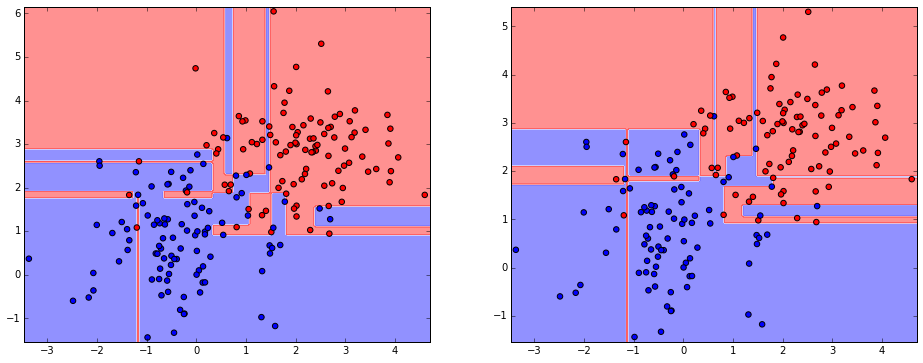

In [3]:
plt.figure(figsize=[16, 6])
plt.subplot(121)
tree = DecisionTreeClassifier(random_state=42).fit(X, y)
plot_classifier_decision(tree, X, y)
plt.subplot(122)
# same, but 20 events were removed
tree = DecisionTreeClassifier(random_state=42).fit(X[20:], y[20:])
plot_classifier_decision(tree, X[20:], y[20:])

# RandomForest

Builds independently many trees. 

Each tree is trained on a part of training data obtained by 
- sampling features (columns) without replacements (**Random Subspace Model**)
- sampling events (rows) with replacement (**bagging**)

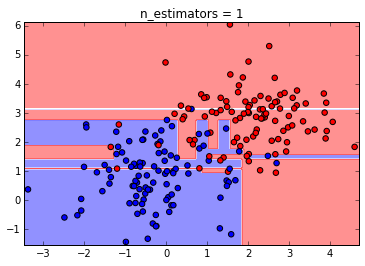

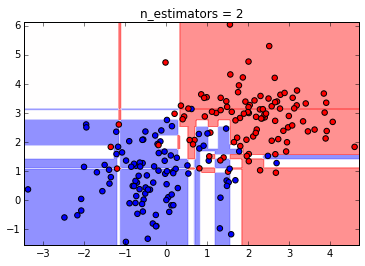

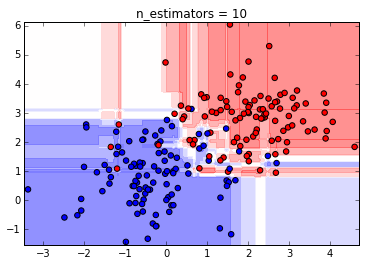

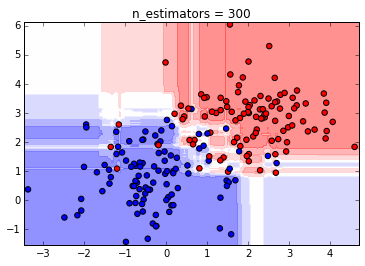

In [4]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
for n_trees in [1, 2, 10, 300]:
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=42).fit(X, y)
    plot_classifier_decision(rf, X, y)
    plt.title('n_estimators = {}'.format(n_trees))
    plt.show()

# Overfitting 

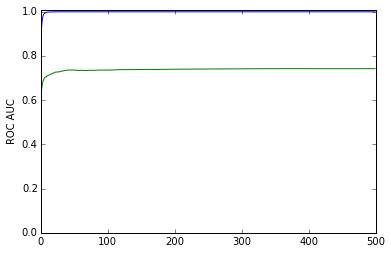

In [5]:
toy_trainX, toy_trainY = make_blobs(n_samples=2000, centers=[[0, 1, 1], [1, 2, 2]], random_state=42, cluster_std=1.5)
toy_testX,  toy_testY = make_blobs(n_samples=2000, centers=[[0, 1, 1], [1, 2, 2]], random_state=3, cluster_std=1.5)
rf = RandomForestClassifier(n_estimators=500).fit(toy_trainX, toy_trainY)


for toyX, toyY, label in [(toy_trainX, toy_trainY, 'train'), (toy_testX, toy_testY, 'test')]:
    predictions = numpy.zeros(len(toyX))
    curve = []
    for tree in rf.estimators_:
        predictions += tree.predict(toyX)
        curve.append(roc_auc_score(toyY, predictions))
    plt.plot(curve)
    plt.ylim(0, 1.01)
    plt.ylabel('ROC AUC')

### Random Forest
- terribly simple
- has huge difference of the quality between predictions on train and validation sample
- it's quality never goes down with increasing the number of trees
- **never overfits**
- huge difference between predictions on test and training does not guarantee the model is bad


But approach used by many physicists today (detect differenct between training and test) says 'it is overfitted' for random forest. So don't use this approach :)

<img src='http://arogozhnikov.github.io/images/etc/no_tmva_plot.gif' width='400' alt='these plots are not useful' />

## also...
- RF efficiently works with features of different scale and nature
- doesn't require tuning 
- for large datasets may produce giant trees (which is long and taked lots of memory). <br />
  Makes sense to limit growth of trees (`max_depth=30` or `min_samples_leaf`)
- works extremely well in many situations.

# Random forest for wines

taking the same splitting

In [6]:
import pandas
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
data = pandas.read_csv('data/2-winequality-white.csv', sep=';')
winesY = data['quality'].values
winesX = data.drop('quality', axis=1)
trainX, testX, trainY, testY = train_test_split(winesX, winesY, random_state=42)

rf_reg = RandomForestRegressor(n_estimators=200).fit(trainX, trainY)
mean_squared_error(testY, rf_reg.predict(testX))

0.35968879591836739

# AdaBoost (Adaptive Boosting, 1997) demonstration

AdaBoost operates by reweighting samples each time. <br />
Weight of sample is increased if base classifier makes a mistake.

Formally this corresponds to minimizing exponential loss function.
In the following demonstration we use trees of depth 1.

<!--- important note - illustration below gives the idea, but numerically incorrect -->

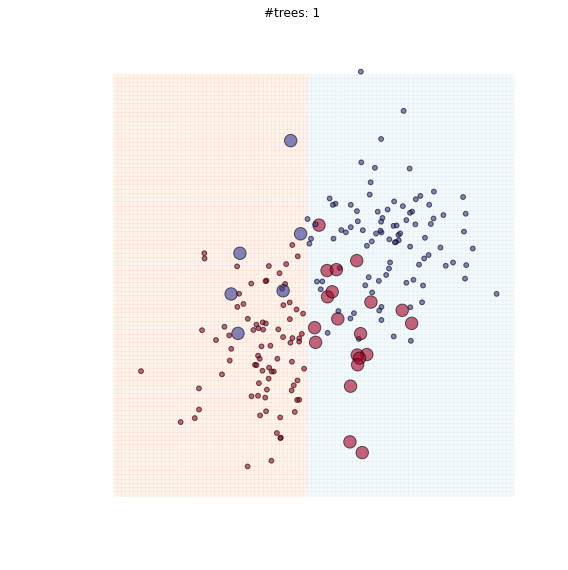

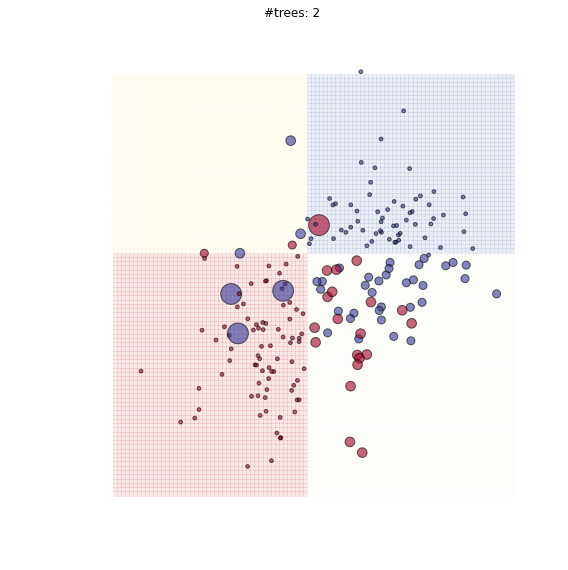

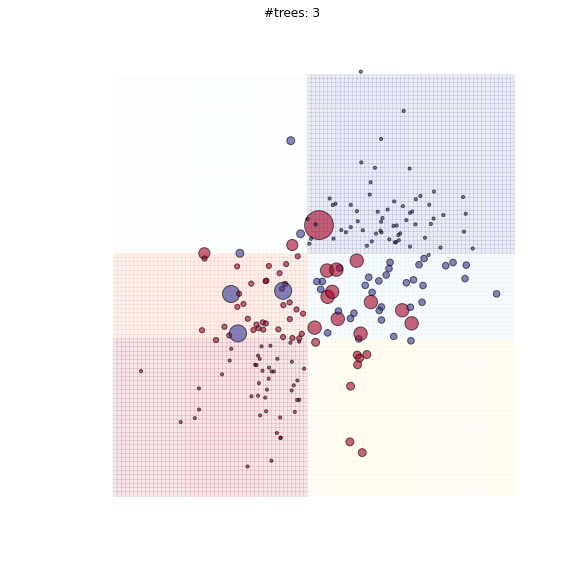

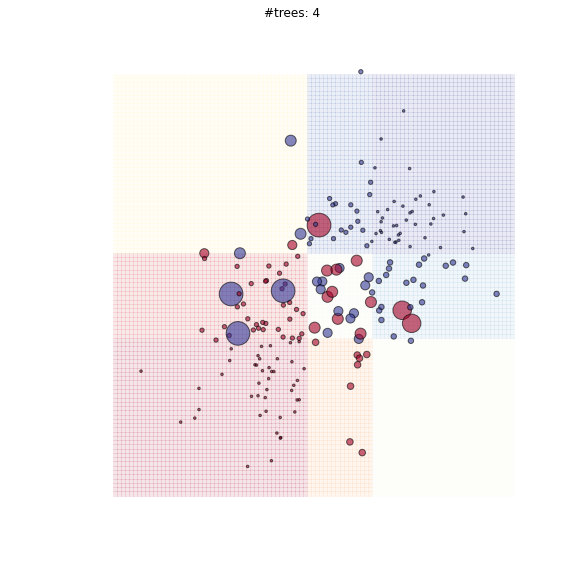

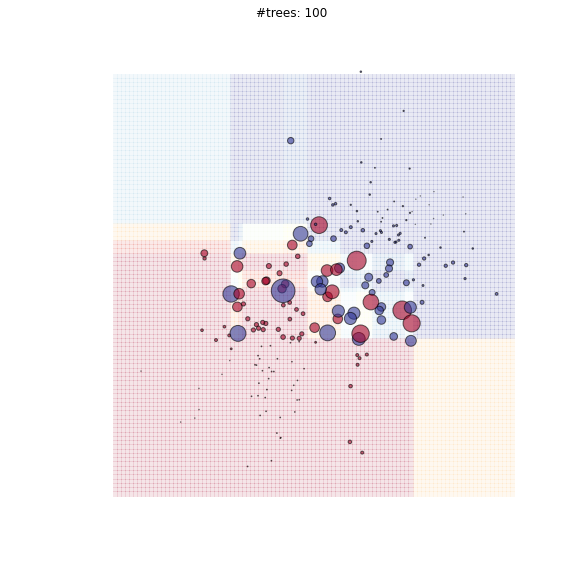

In [7]:
# Hand-made AdaBoost! It's quite simple!
xx, yy = numpy.meshgrid(numpy.linspace(-4, 5, 100), numpy.linspace(-2, 6, 100))
weights = numpy.ones(len(X))
Z = 0 * xx.flatten()
Z[0] = 0.1
Z[-1] = -0.1

for iteration in range(101):
    if iteration in [1, 2, 3, 4, 100]:
        plt.figure(figsize=[8, 8])
        plt.pcolormesh(xx, yy, Z.reshape(xx.shape),  alpha=0.1, cmap='RdYlBu', vmin=-2, vmax=2)
        plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.6, s=40 * weights / weights.mean(), cmap='RdYlBu')
        plt.axis('off')
        plt.title('#trees: {}'.format(iteration))
        plt.tight_layout()
    

    tree = DecisionTreeClassifier(max_depth=1).fit(X, y, sample_weight=weights)
    is_correct = (y == tree.predict(X))
    alpha = 0.5 * numpy.log(numpy.sum(is_correct * weights) / numpy.sum((1 - is_correct) * weights))
    weights *= numpy.exp(- alpha * (2 * is_correct - 1))
    Z = Z + alpha * (2 * tree.predict(numpy.c_[xx.ravel(), yy.ravel()]) - 1)

In [8]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
clf = AdaBoostClassifier(n_estimators=100, 
                         base_estimator=DecisionTreeClassifier(max_depth=3))
# you can train AdaBoost over other classifiers

clf = AdaBoostClassifier(n_estimators=100, 
                         base_estimator=GaussianNB())

# GB demonstration

GBDT approximates target dependency by making steps in the space of functions:

<img src='http://arogozhnikov.github.io/images/etc/rogozhnikov_gb_visualization.png' />

# GB tuning

AdaBoost is a particular case of Gradient Boosting.

Sklearn's [tutorial](http://nbviewer.jupyter.org/urls/s3.amazonaws.com/datarobotblog/notebooks/gbm-tutorial.ipynb) on tuning GBDT.

GB = GBDT = GBRT = GBM = MART, these are names of same approach.

## Working with GB in sklearn

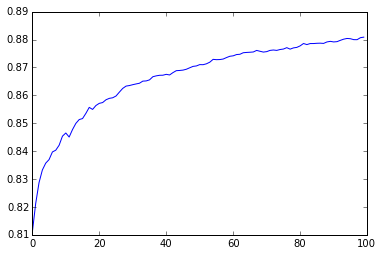

In [9]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4)
new_trainY = trainY > 6
new_testY = testY > 6
gb_clf.fit(trainX, new_trainY)

test_qualities = []
for p in gb_clf.staged_predict_proba(testX):
    test_qualities.append(roc_auc_score(new_testY, p[:, 1]))
plt.plot(test_qualities)

# Higgs sample submission using RandomForest

To make challenge even more physical, the data is stored in ROOT - beloved format in HEP. <br />
ROOT keeps your data fresh and healthy! (joking)



In [10]:
from IPython.display import FileLink
def create_solution(predictions, filename='2-higgs-decay-predictions.csv'):
    result = pandas.DataFrame({'EventId': numpy.arange(len(predictions)), 'Label': predictions})
    result.to_csv('data/{}'.format(filename), index=False)
    return FileLink('data/{}'.format(filename))

In [11]:
import root_numpy

all_train = pandas.DataFrame(root_numpy.root2array('./data/3-Higgs_training.root', treename='data'))

y = all_train.Label.values
w = all_train.Weight.values
X = all_train.drop(['Label', 'Weight'], axis=1)

In [13]:
trainX, testX, trainY, testY, trainW, testW = train_test_split(X, y, w, random_state=42)

In [14]:
trainX.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
90842,133.931,37.435,105.231,101.530,4.690,644.736,-4.515,2.900,29.498,261.915,...,2.952,309.313,2,76.615,-3.337,1.221,49.352,1.353,-0.774,125.967
208668,118.685,80.239,94.042,139.889,1.108,167.790,-0.270,2.284,60.418,375.339,...,-0.346,430.095,3,104.532,-0.362,2.587,83.686,0.746,-2.231,224.572
120293,100.818,84.426,84.290,0.141,-999.000,-999.000,-999.000,2.554,0.141,88.558,...,-2.785,78.788,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
98990,82.025,4.392,45.541,114.083,-999.000,-999.000,-999.000,1.264,1.488,193.378,...,2.049,258.721,1,113.710,-1.088,-1.489,-999.000,-999.000,-999.000,113.710
194631,99.361,17.711,55.792,69.790,-999.000,-999.000,-999.000,2.101,2.403,131.293,...,3.089,157.375,1,67.486,1.100,-0.379,-999.000,-999.000,-999.000,67.486


In [15]:
test_data = pandas.DataFrame(root_numpy.root2array('./data/3-Higgs_test.root', treename='data'))
test_data = test_data.drop('EventId', axis=1)

In [16]:
clf = RandomForestClassifier(n_estimators=10, max_depth=30)
# don't forget to compute quality on cross-validation!
clf.fit(trainX, trainY, sample_weight=trainW)
create_solution(clf.predict_proba(test_data)[:, 1])

/Users/antares/Yandex.Disk.localized/MLatImperial2016private/data/2-higgs-decay-predictions.csv

To be submitted to the [kaggle competition](https://inclass.kaggle.com/c/higgs-competition)


## Weights in Machine Learning

- weights are proportional to probabilities 
- weights are always non-negative (sWeights are not weights!)
- being put in ML, they drive to different problems (i.e. non-convex optimization losses)
- heuristically sWeights may work
- avoid using negative weights

## Stacking (stacked generalization)

<img src='http://arogozhnikov.github.io/images/etc/rogozhnikov_stacking.png' />

# Homework (due to Wednesday, 3rd Feb)

** Exercise #0. ** Compare results of well-tuned decision tree and stock RandomForest with 300 trees on Higgs Dataset. Submit both to the kaggle.

** Exercise #1. ** Look at feature importances of RandomForest. (use `clf.feature_importances_`)

** Exercise #2. ** (Optional) Are you able to provide comparable quality of classification with linear models?
    (Take a linear model and provide it with new features)

** Major Goal. ** Participate in Higgs kaggle (shall be approved soon)! Don't forget about feature engineering.

When done, save the changes and download notebook. Rename to `3 - Surname - ensembling.ipynb` and send to `icl.ml@yandex.ru`

### exercise 0

In [17]:
# tune tree parameters
for depth in [4, 5, 6, 8, 10]:
    for min_sample_leaf in [10, 50, 100, 1000]:
        for min_sample_split in [50, 100, 500, 10000]:
            tree_clf = DecisionTreeClassifier(max_depth=depth,
                                              min_samples_leaf=min_sample_leaf,
                                              min_samples_split=min_sample_split)
            tree_clf.fit(trainX, trainY, sample_weight=trainW)
            print depth, min_sample_leaf, min_sample_split,
            print roc_auc_score(testY, tree_clf.predict_proba(testX)[:, 1], sample_weight=testW)

4 10 50 0.829406506343
4 10 100 0.829406506343
4 10 500 0.829406506343
4 10 10000 0.828776962146
4 50 50 0.854397205369
4 50 100 0.854397205369
4 50 500 0.854397205369
4 50 10000 0.852295666576
4 100 50 0.854397205369
4 100 100 0.854397205369
4 100 500 0.854397205369
4 100 10000 0.852295666576
4 1000 50 0.861217675868
4 1000 100 0.861217675868
4 1000 500 0.861217675868
4 1000 10000 0.85583813023
5 10 50 0.855735748863
5 10 100 0.855735748863
5 10 500 0.855735748863
5 10 10000 0.85421786681
5 50 50 0.873450774118
5 50 100 0.873450774118
5 50 500 0.873450774118
5 50 10000 0.864273764749
5 100 50 0.873448791505
5 100 100 0.873448791505
5 100 500 0.873448791505
5 100 10000 0.864262482272
5 1000 50 0.874554418615
5 1000 100 0.874554418615
5 1000 500 0.874554418615
5 1000 10000 0.865857440393
6 10 50 0.87209125427
6 10 100 0.87209125427
6 10 500 0.87209125427
6 10 10000 0.864277994844
6 50 50 0.88460095607
6 50 100 0.88460095607
6 50 500 0.884578600591
6 50 10000 0.871018132874
6 100 50 0.88

In [18]:
# simple random forest
rf_clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=42)
%time rf_clf.fit(trainX, trainY, sample_weight=trainW)
roc_auc_score(testY, rf_clf.predict_proba(testX)[:, 1], sample_weight=testW)

CPU times: user 8min 31s, sys: 3.55 s, total: 8min 35s
Wall time: 8min 41s


0.75713023922343836

Result of random forest is poor, and result of one tree is impressive. 

This is strange, because theory says, that random forest should perform essentially better than single tree. The problem can be in sample weights and inbalanced data (amount of one class is dominated over another one). Let's look at the sample weights!

#### proportion of 0, 1-labeled without weights

In [22]:
sum(y == 0), sum(y == 1)

(164333, 85667)

In [23]:
# we train simple random forest without weights
rf_clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=42)
%time rf_clf.fit(trainX, trainY)
roc_auc_score(testY, rf_clf.predict_proba(testX)[:, 1], sample_weight=testW)

CPU times: user 5min 43s, sys: 3.36 s, total: 5min 47s
Wall time: 5min 51s


0.91448943015901873

Now we see that random forest works! Not using weights is a bad idea, so let's try to fix this issue.

#### normalize sum of weights for both classes

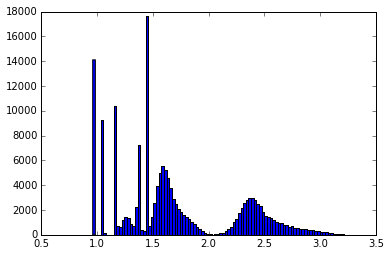

In [43]:
plt.hist(w[y == 0], bins=100)
pass

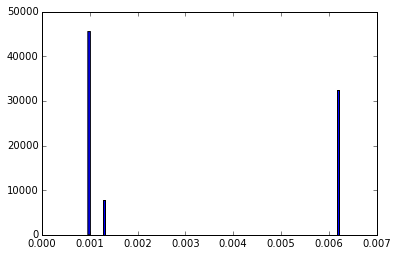

In [45]:
plt.hist(w[y == 1], bins=100)
pass

In [46]:
sum(w[y == 0]), sum(w[y == 1])

(280119.58703553787, 255.25152617040916)

Zero-labeled data have strongly greater sum of weights. That is why one-labeled predictions in the leaf will be suppresed by zero-labeled predictions: averaging over samples in a leaf and averaging over trees will always work in region around zero. 

Consequenltly, it is necessary to normalize sample weights. For instance:

In [24]:
w_normed = w.copy()
w_normed[y == 1] *= 1000

In [25]:
sum(w_normed[y == 0]), sum(w_normed[y == 1])

(280119.58703553787, 255251.52617079986)

In [26]:
trainX, testX, trainY, testY, trainW, testW = train_test_split(X, y, w_normed, random_state=42)

In [27]:
for depth in [4, 5, 6, 8, 10]:
    for min_sample_leaf in [10, 50, 100, 1000]:
        for min_sample_split in [50, 100, 500, 10000]:
            tree_clf = DecisionTreeClassifier(max_depth=depth,
                                              min_samples_leaf=min_sample_leaf,
                                              min_samples_split=min_sample_split)
            tree_clf.fit(trainX, trainY, sample_weight=trainW)
            print depth, min_sample_leaf, min_sample_split,
            print roc_auc_score(testY, tree_clf.predict_proba(testX)[:, 1], sample_weight=testW)

4 10 50 0.869001550197
4 10 100 0.869001550197
4 10 500 0.869001550197
4 10 10000 0.867183066745
4 50 50 0.869001550197
4 50 100 0.869001550197
4 50 500 0.869001550197
4 50 10000 0.867183066745
4 100 50 0.869001550197
4 100 100 0.869001550197
4 100 500 0.869001550197
4 100 10000 0.867183066745
4 1000 50 0.868874224595
4 1000 100 0.868874224595
4 1000 500 0.868874224595
4 1000 10000 0.867183066745
5 10 50 0.879827173616
5 10 100 0.879827173616
5 10 500 0.879827173616
5 10 10000 0.876722035773
5 50 50 0.879854267008
5 50 100 0.879854267008
5 50 500 0.879854267008
5 50 10000 0.876722035773
5 100 50 0.879979516111
5 100 100 0.879979516111
5 100 500 0.879979516111
5 100 10000 0.876722035773
5 1000 50 0.879409158276
5 1000 100 0.879409158276
5 1000 500 0.879409158276
5 1000 10000 0.876710830112
6 10 50 0.888330402168
6 10 100 0.888330402168
6 10 500 0.888314251139
6 10 10000 0.88066583715
6 50 50 0.888333139167
6 50 100 0.888333139167
6 50 500 0.888323447217
6 50 10000 0.88066583715
6 100 50

In [28]:
rf_clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=42)
%time rf_clf.fit(trainX, trainY, sample_weight=trainW)
roc_auc_score(testY, rf_clf.predict_proba(testX)[:, 1], sample_weight=testW)

CPU times: user 5min 25s, sys: 1.99 s, total: 5min 27s
Wall time: 5min 29s


0.91458811304215781

Tree provides 0.90 AUC (parameters `depth=10`, `min_sample_leaf=100`, `min_sample_split=50`), while random forest provides better result 0.914

### exercise 1

In [29]:
pandas.DataFrame({'importance': rf_clf.feature_importances_, 'features': trainX.columns}).sort_values(by='importance')

,features,importance
22,PRI_jet_num,0.003587
28,PRI_jet_subleading_phi,0.003609
26,PRI_jet_subleading_pt,0.003822
27,PRI_jet_subleading_eta,0.003927
12,DER_lep_eta_centrality,0.004927
6,DER_prodeta_jet_jet,0.005184
5,DER_mass_jet_jet,0.005554
4,DER_deltaeta_jet_jet,0.006122
23,PRI_jet_leading_pt,0.012411
25,PRI_jet_leading_phi,0.012436


Different mass features are the most important for the algorithm

### exercise 2

Different linear models **without feature engineering**

In [108]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

In [109]:
clf_scale = StandardScaler().fit(trainX, trainY)
clf = SGDClassifier(loss='log', n_iter=100)
clf.fit(clf_scale.transform(trainX), trainY, sample_weight=trainW)
roc_auc_score(testY, clf.predict_proba(clf_scale.transform(testX))[:, 1], sample_weight=testW)

0.85096338753520973

In [110]:
from sklearn.linear_model import LogisticRegression
lin_clf = LogisticRegression(C=100)
lin_clf.fit(trainX, trainY) # logistic regression doesn't support sample_weight
print roc_auc_score(testY, lin_clf.predict_proba(testX)[:, 1], sample_weight=testW)

0.842795964493
